# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [4]:
!pip install optuna optuna-dashboard

In [5]:
import optuna
import optuna.visualization as vis
import time

import scipy.stats as st

from sklearn.datasets import  fetch_california_housing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer

from sklearn.model_selection import cross_val_score

In [6]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [9]:
# Fill missing numerical values with median
spaceship.fillna(spaceship.median(numeric_only=True), inplace=True)

# Convert categorical variables into numerical using One-Hot Encoding
spaceship = pd.get_dummies(spaceship, drop_first=True)

# Display the updated dataset
spaceship.head()



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_0002_01,PassengerId_0003_01,PassengerId_0003_02,...,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne
0,39.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
# Step 4: Convert categorical variables to numeric
spaceship = pd.get_dummies(spaceship, drop_first=True)

# Step 5: Apply feature scaling (Standardization)
scaler = StandardScaler()  # OR use MinMaxScaler() if normalization is preferred
spaceship_scaled = scaler.fit_transform(spaceship)

# Convert back to DataFrame
spaceship_scaled = pd.DataFrame(spaceship_scaled, columns=spaceship.columns)


In [11]:
# Step 6: Feature Selection
X = spaceship_scaled.drop(columns=['Transported'])  # Features
y = spaceship['Transported']  # Target variable

selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top Selected Features:\n", selected_features)

Top Selected Features:
 Index(['Age', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck', 'HomePlanet_Europa',
       'CryoSleep_True', 'Cabin_G/981/S', 'Destination_TRAPPIST-1e',
       'VIP_True'],
      dtype='object')


- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [13]:

# Encoding categorical variables using One-Hot Encoding
spaceship = pd.get_dummies(spaceship, drop_first=True)

# Splitting the target variable
X = spaceship.drop(columns=["Transported"])  # Features
y = spaceship["Transported"]  # Target variable

# Splitting the dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Checking the shapes of the train-test split
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (6954, 23735)
Testing Set Shape: (1739, 23735)


Gradient Boosting Accuracy: 0.8005


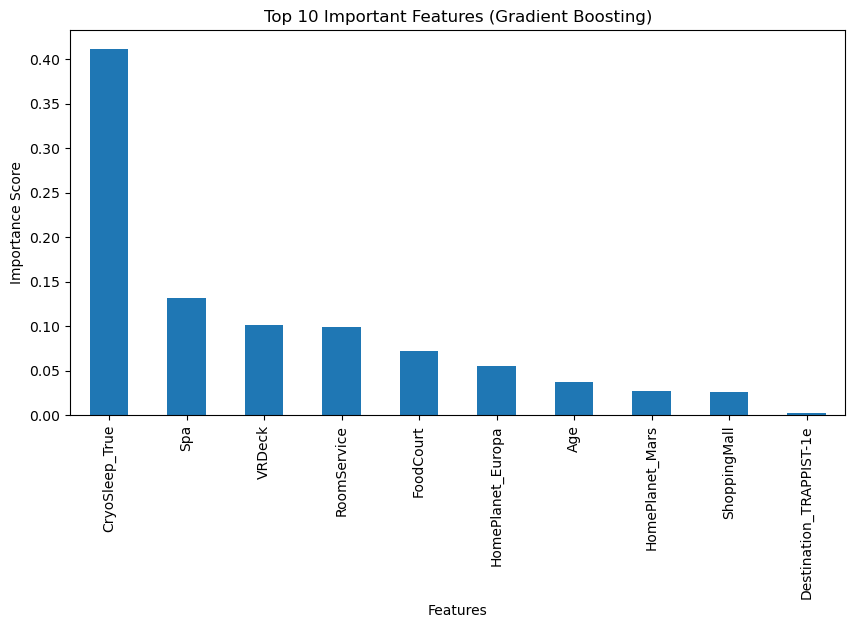

In [14]:
#your code here
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,  # Depth of individual trees
    random_state=42
)

# Train the model
gb_clf.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_clf.predict(X_test)

# Evaluate accuracy
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")


import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feature_importance = pd.Series(gb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
feature_importance[:10].plot(kind='bar')
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

- Evaluate your model

**Grid/Random Search**

For this lab we will use Grid Search.

- Define hyperparameters to fine tune.

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Optimized Gradient Boosting Accuracy: 0.7568


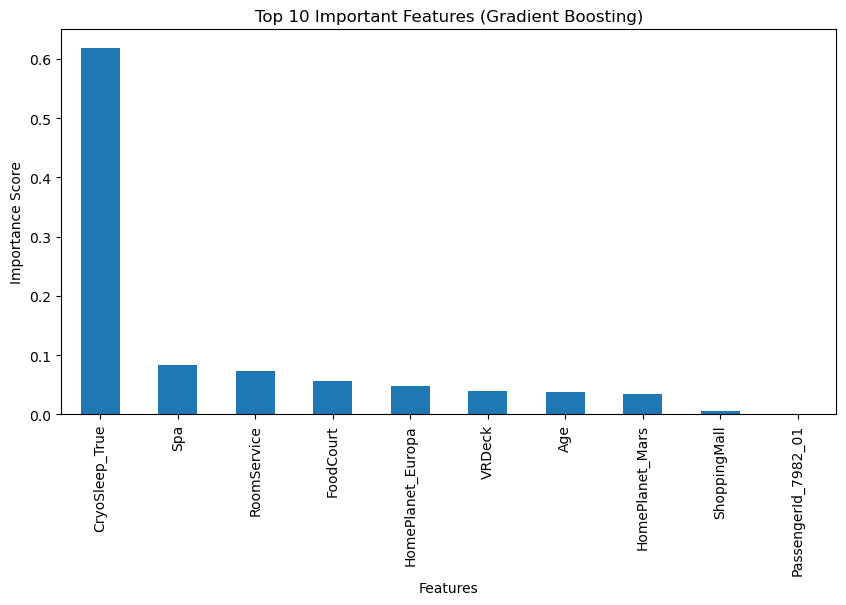

In [19]:
#your code here
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100],  # Number of trees
    'learning_rate': [0.01],  # Shrinkage factor
    'max_depth': [3],  # Tree depth
}

# Initialize Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_gb_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions
y_pred_gb = best_gb_clf.predict(X_test)

# Evaluate accuracy
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Optimized Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Get feature importance
feature_importance = pd.Series(best_gb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
feature_importance[:10].plot(kind='bar')
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


- Run Grid Search

- Evaluate your model